In [1]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, utils
from gensim.models import LdaModel
from gensim import similarities
from gensim.models.phrases import Phrases, Phraser

import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from cleantext import clean

from wordcloud import WordCloud
import seaborn as sns

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [2]:
cv_data = pd.read_csv('../data/cv_data.csv' ,encoding='utf-8')
cv_data.head()

,category,resume
0,Data Science,Skills Programming Languages Python pandas num...
1,Data Science,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,Areas of Interest Deep Learning Control System...
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...


In [3]:
def preprocess_text(text):
    # Tokenize text
    tokens = text.lower().split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [4]:
# Preprocess resumes
preprocessed_cv = cv_data['resume'].apply(preprocess_text)

In [5]:
# Create dictionary representation of resumes
dictionary = corpora.Dictionary(preprocessed_cv)

In [6]:
# Load LDA model
lda_model = models.LdaModel.load("../model/lda_model_ba")

In [7]:
# Create document-term matrix using the loaded dictionary
doc_term_matrix = [lda_model.id2word.doc2bow(desc) for desc in preprocessed_cv]

In [8]:
# Infer topics for resumes using the loaded LDA model
topics = [lda_model.get_document_topics(doc) for doc in doc_term_matrix]

In [9]:
# Print the inferred topics for each resume in the new dataset
for doc_topics in topics:
    for topic, prob in doc_topics:
        print(f"Topic: {topic} | Probability: {prob}")
    print()

Topic: 1 | Probability: 0.10620670765638351
Topic: 2 | Probability: 0.09206854552030563
Topic: 3 | Probability: 0.10220080614089966
Topic: 5 | Probability: 0.43327003717422485
Topic: 6 | Probability: 0.1023179292678833
Topic: 7 | Probability: 0.06470508128404617
Topic: 9 | Probability: 0.09856636822223663

Topic: 1 | Probability: 0.21990011632442474
Topic: 3 | Probability: 0.07873373478651047
Topic: 5 | Probability: 0.2838427722454071
Topic: 6 | Probability: 0.3561176061630249
Topic: 9 | Probability: 0.056714583188295364

Topic: 1 | Probability: 0.15832307934761047
Topic: 2 | Probability: 0.03343525156378746
Topic: 5 | Probability: 0.2960478961467743
Topic: 6 | Probability: 0.3027409613132477
Topic: 7 | Probability: 0.12526924908161163
Topic: 9 | Probability: 0.08181208372116089

Topic: 1 | Probability: 0.12060940265655518
Topic: 2 | Probability: 0.27620458602905273
Topic: 3 | Probability: 0.037555791437625885
Topic: 5 | Probability: 0.46425774693489075
Topic: 6 | Probability: 0.058574

In [10]:
# Extract topic probabilities and consolidate in the CV dataset
for i, doc_topics in enumerate(topics):
    topic_probs = [0.0] * lda_model.num_topics
    for topic, prob in doc_topics:
        topic_probs[topic] = prob
    for j, prob in enumerate(topic_probs):
        cv_data.loc[i, f"Topic_{j} Probability"] = prob

cv_data.head()

,category,resume,Topic_0 Probability,Topic_1 Probability,Topic_2 Probability,Topic_3 Probability,Topic_4 Probability,Topic_5 Probability,Topic_6 Probability,Topic_7 Probability,Topic_8 Probability,Topic_9 Probability
0,Data Science,Skills Programming Languages Python pandas num...,0.0,0.106207,0.092069,0.102201,0.0,0.433270,0.102318,0.064705,0.0,0.098566
1,Data Science,Education Details May 2013 to May 2017 B E UIT...,0.0,0.219900,0.000000,0.078734,0.0,0.283843,0.356118,0.000000,0.0,0.056715
2,Data Science,Areas of Interest Deep Learning Control System...,0.0,0.158323,0.033435,0.000000,0.0,0.296048,0.302741,0.125269,0.0,0.081812
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...,0.0,0.120609,0.276205,0.037556,0.0,0.464258,0.058575,0.031647,0.0,0.000000
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,0.0,0.089798,0.000000,0.000000,0.0,0.346675,0.547612,0.000000,0.0,0.000000


In [11]:
# Calculate the average probability for each resume across all topics
cv_data['Qualification Score'] = cv_data[[f"Topic_{j} Probability" for j in range(lda_model.num_topics)]].mean(axis=1)

cv_data.head()

,category,resume,Topic_0 Probability,Topic_1 Probability,Topic_2 Probability,Topic_3 Probability,Topic_4 Probability,Topic_5 Probability,Topic_6 Probability,Topic_7 Probability,Topic_8 Probability,Topic_9 Probability,Qualification Score
0,Data Science,Skills Programming Languages Python pandas num...,0.0,0.106207,0.092069,0.102201,0.0,0.433270,0.102318,0.064705,0.0,0.098566,0.099934
1,Data Science,Education Details May 2013 to May 2017 B E UIT...,0.0,0.219900,0.000000,0.078734,0.0,0.283843,0.356118,0.000000,0.0,0.056715,0.099531
2,Data Science,Areas of Interest Deep Learning Control System...,0.0,0.158323,0.033435,0.000000,0.0,0.296048,0.302741,0.125269,0.0,0.081812,0.099763
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...,0.0,0.120609,0.276205,0.037556,0.0,0.464258,0.058575,0.031647,0.0,0.000000,0.098885
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,0.0,0.089798,0.000000,0.000000,0.0,0.346675,0.547612,0.000000,0.0,0.000000,0.098408


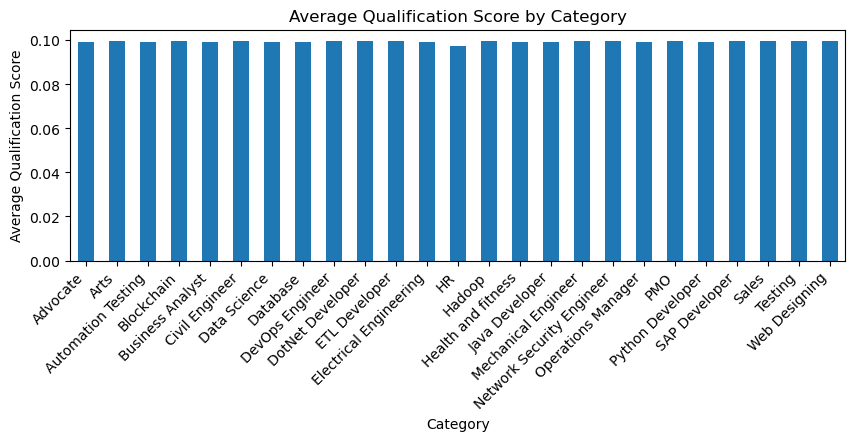

In [12]:
# Calculate the average qualification score for each category
average_scores = cv_data.groupby('category')['Qualification Score'].mean()

# Plot a bar chart of the average scores
plt.figure(figsize=(10, 3))
ax = average_scores.plot(kind='bar')
ax.set_xlabel('Category')
ax.set_ylabel('Average Qualification Score')
ax.set_title('Average Qualification Score by Category')
ax.set_xticklabels(average_scores.index, rotation=45, ha='right')
plt.show()

### Cosine similarity score

In [13]:
#Import data files
jd_ba = pd.read_csv("../data/jd_ba.csv",encoding='utf-8')
jd_ba.head()

,description
0,Company Overview At Memorial Sloan Kettering M...
1,We are seeking for an energetic and collaborat...
2,For more than a decade Asembia has been workin...
3,Job Description Summary The Information Securi...
4,Magnite is the world s largest independent sel...


In [14]:
def preprocess_text(text):
    # Tokenize text
    tokens = text.lower().split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [15]:
# Preprocess job descriptions
preprocessed_job_description = jd_ba['description'].apply(preprocess_text)

In [16]:
# Create a TfidfVectorizer
vectorizer = TfidfVectorizer()

In [17]:
# Fit and transform the job description
job_description_vector = vectorizer.fit_transform([' '.join(preprocessed_job_description[0])])

# Calculate cosine similarity between each resume and the job description
similarity_scores = []
for preprocessed_resume in preprocessed_cv:
    resume_vector = vectorizer.transform([' '.join(preprocessed_resume)])
    similarity_score = cosine_similarity(resume_vector, job_description_vector)[0][0]
    similarity_scores.append(similarity_score)


In [18]:
# Add similarity scores to the CV dataset
cv_data['Similarity Score'] = similarity_scores
cv_data.head()

,category,resume,Topic_0 Probability,Topic_1 Probability,Topic_2 Probability,Topic_3 Probability,Topic_4 Probability,Topic_5 Probability,Topic_6 Probability,Topic_7 Probability,Topic_8 Probability,Topic_9 Probability,Qualification Score,Similarity Score
0,Data Science,Skills Programming Languages Python pandas num...,0.0,0.106207,0.092069,0.102201,0.0,0.433270,0.102318,0.064705,0.0,0.098566,0.099934,0.353218
1,Data Science,Education Details May 2013 to May 2017 B E UIT...,0.0,0.219900,0.000000,0.078734,0.0,0.283843,0.356118,0.000000,0.0,0.056715,0.099531,0.177784
2,Data Science,Areas of Interest Deep Learning Control System...,0.0,0.158323,0.033435,0.000000,0.0,0.296048,0.302741,0.125269,0.0,0.081812,0.099763,0.199409
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...,0.0,0.120609,0.276205,0.037556,0.0,0.464258,0.058575,0.031647,0.0,0.000000,0.098885,0.310457
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,0.0,0.089798,0.000000,0.000000,0.0,0.346675,0.547612,0.000000,0.0,0.000000,0.098408,0.127462


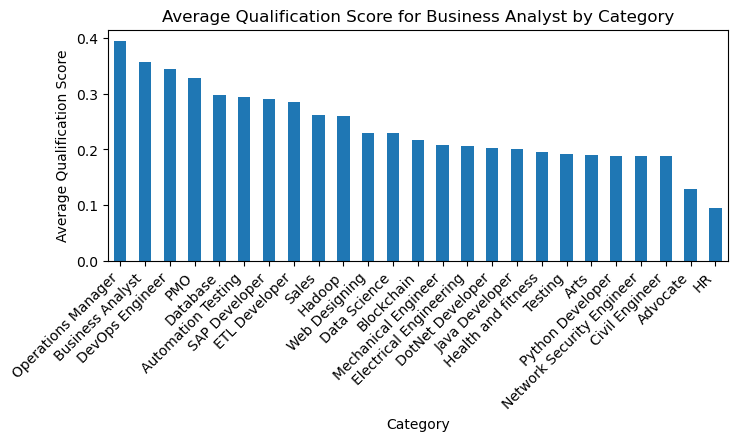

In [22]:
# Calculate the average qualification score for each category
average_scores = cv_data.groupby('category')['Similarity Score'].mean()

# Sort the average scores in descending order
ba_average_scores_sorted = average_scores.sort_values(ascending=False)

# Plot a bar chart of the sorted average scores
plt.figure(figsize=(8, 3))
ax = ba_average_scores_sorted.plot(kind='bar')
ax.set_xlabel('Category')
ax.set_ylabel('Average Qualification Score')
ax.set_title('Average Qualification Score for Business Analyst by Category')
ax.set_xticklabels(ba_average_scores_sorted.index, rotation=45, ha='right')
plt.show()


In [20]:
average_scores.sort_values(ascending=False)

category
Operations Manager           0.395369
Business Analyst             0.357250
DevOps Engineer              0.343431
PMO                          0.328912
Database                     0.298126
Automation Testing           0.293268
SAP Developer                0.291076
ETL Developer                0.284485
Sales                        0.262176
Hadoop                       0.259733
Web Designing                0.230097
Data Science                 0.229625
Blockchain                   0.215913
Mechanical Engineer          0.208027
Electrical Engineering       0.205591
DotNet Developer             0.201801
Java Developer               0.201341
Health and fitness           0.195911
Testing                      0.191376
Arts                         0.189103
Python Developer             0.187998
Network Security Engineer    0.187562
Civil Engineer               0.187042
Advocate                     0.128546
HR                           0.094137
Name: Similarity Score, dtype: float64